# Explorations of the Void, using methods such as Zero crossing rate, PCA and clustering  - 08/11/2020

This contains much of th initial study on various methods in the frequency and time domains. these methods are relatively easy to use and have been used successfully in many other related applications, such as natural sounds like bird noises. an audio sample of an actual void was found online and used. this piece of audio wa not very high quality and will make detection very difficult. however, it should be fine for demonstration purposes.





In [65]:
import numpy as np 
import librosa 
import matplotlib.pyplot as plt
import librosa.display 
from sklearn.cluster import KMeans
from matplotlib.patches import Rectangle
plt.rcParams['figure.figsize'] = [10, 5]
void_15 = "./data/youtube/voids/void1_15.wav"
void_audio = './data/youtube/voids/void1.wav'
#void_audio = './data/youtube/wav/7_cropped_reduced.wav'
x_synth, sr = librosa.load("./data/synthetic/7_with_void.wav")

sr = 22050
x = librosa.load(void_audio, sr= 22050)[0]
x_15 = librosa.load(void_15)[0]
duration = len(x)/22050

import pandas as pd 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


## Zero crossing rate - 08/11/2020 

This is how often the signal crosses zero. the calculation involves looking at each sample in the time domain and seeing whether the sign of the signal changes in the next sample. a high zcr could indicate that voice activity was present. 
$$Z(i) = \frac{1}{2N} \sum_{n=1}^N |sgn[x_i(n)]-sgn[x_i(n-1)]|$$

214


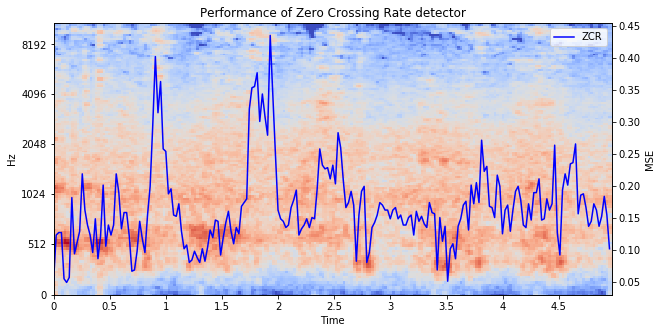

In [66]:
def zc_rate(x):
    # the zero crossing rate can be computed as follows:
    y_zcross = librosa.feature.zero_crossing_rate(x,frame_length=512)

    print(len(y_zcross[0]))
    ax = plt.subplot()
    x_ft = abs(librosa.feature.melspectrogram(x))#n_mels = 128, fmax = 1024))
    duration = len(x)/22050

    xt = np.linspace(0,duration,len(y_zcross[0]))

    #X_std = StandardScaler().fit_transform(x_ft.T).T

    ax2 = ax.twinx() 
    librosa.display.specshow(librosa.power_to_db(x_ft),x_axis="time",y_axis="mel",ax=ax)
    ax2.plot(xt,y_zcross[0], c = "b", label = "ZCR")
    ax2.set_ylabel("MSE")
    ax2.set_title("Performance of Zero Crossing Rate detector")
    plt.legend()
    plt.show()

ax, fig = plt.subplots(111)
zc_rate(x_15)
# james.crossley 

## 18/11/2020

The above inplementation did not work so well, as the noise is really significant and there is a lot of high frequency noise which results in a high zcr. this is more suited to a very much quiet environment with some white noise. This is not true in this case. 

## Spectral centroid 11/11/2020
This is the weighted mean of the frequencies, the centre of gravity of magnitude spectrum 
Frequency band where most of the energy is concentrated 
Measure of "Brightness" of sound. 

This is used for Audio classification and music classification.

$$ SC_t = \frac{\sum_{n=1}^N m_t(n)*n}{\sum_{n=1}^N m_t(n)} $$

128


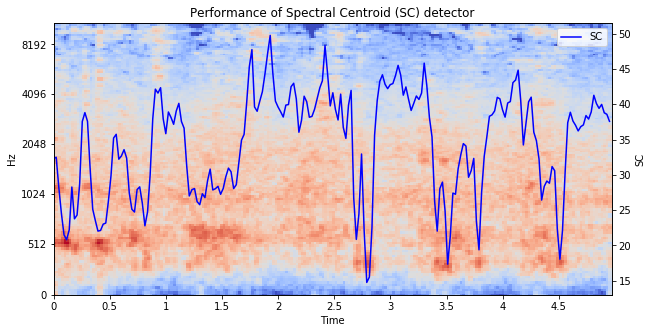

In [57]:
def sc(x):
    x_ft = abs(librosa.feature.melspectrogram(x))
    print(len(x_ft))
    ax=plt.subplot()
    ax2 = ax.twinx()
    librosa.display.specshow(librosa.power_to_db(x_ft),x_axis="time",y_axis="mel",ax=ax)
    centroids=[]
    for i in range(len(x_ft[0])): #for each frame
        centroid = np.dot(x_ft[:,i],np.linspace(0,len(x_ft),len(x_ft))/sum(x_ft[:,i]))
        centroids.append(centroid)
    dur = len(x)/22050
    xt = np.linspace(0,dur,len(centroids))
    ax2.plot(xt,centroids, c = "b", label = "SC")
    ax2.set_ylabel("SC")
    ax2.set_title("Performance of Spectral Centroid (SC) detector")

    plt.legend()
    plt.show()
    
sc(x_15)
    

## Band Energy Ratio   12/11/2020
This is the ratio between high frequencies and low frequencies, at a particular split frequency. 

$$ BER_t = \frac{\sum_{n=1}^{F-1} m_t(n)^2}{\sum_{n=F}^N m_t(n)^2}$$



(128, 214)


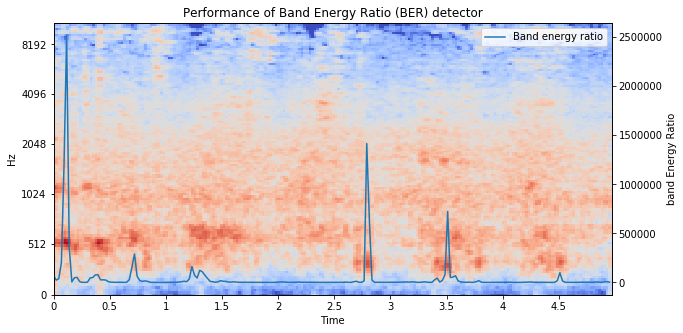

In [64]:
def be_ratio(x,spl):
    x_ft = abs(librosa.feature.melspectrogram(x))
    print(x_ft.shape)
    bers =[]
    for i in range(np.shape(x_ft)[1]): # loop over the frames 
        # the ber for the frame is 
        ber = np.dot(x_ft[:spl-1,i],x_ft[:spl-1,i])/np.dot(x_ft[spl:,i],x_ft[spl:,i])
        bers.append(ber)
    ax = plt.subplot()
    ax2 = ax.twinx()
    librosa.display.specshow(librosa.power_to_db(x_ft),x_axis="time",y_axis="mel",ax=ax)
    dur = len(x)/22050
    xt = np.linspace(0,dur,len(bers))
    ax2.plot(xt,bers, label = "Band energy ratio")
    ax2.set_ylabel("band Energy Ratio")
    ax2.set_title("Performance of Band Energy Ratio (BER) detector")
    plt.legend()
    plt.show()
    
    
be_ratio(x_15,80)

## Bandwidth  12/11/2020
This the weighted mean of the distances of frequency bands from the spectral centroid

$$BW_t = \frac{\sum_{n=1}^N |n-SC_t| * m_t(n)}{\sum_{n=1}^N m_t(n)}$$

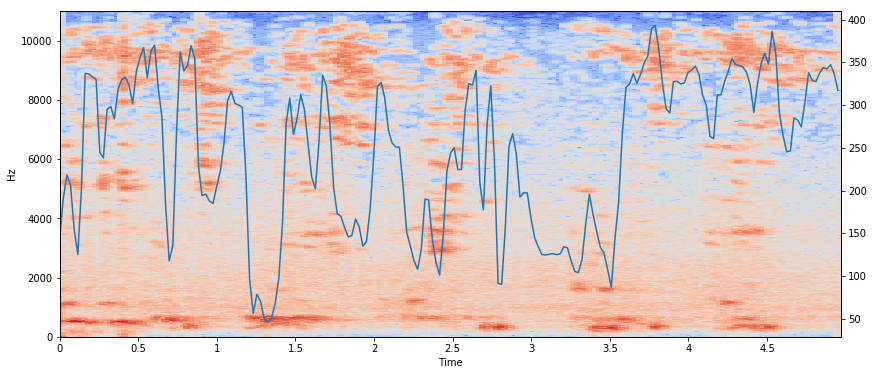

In [254]:
def bandwidth(x):
    x_ft = abs(librosa.stft(x))
    ax = plt.subplot()
    librosa.display.specshow(librosa.power_to_db(x_ft), ax=ax, x_axis="time", y_axis="hz")
    ax2 = ax.twinx()
    centroids = []
    for i in range(np.shape(x_ft)[1]):
        centroid = np.dot(x_ft[:,i],np.linspace(0,len(x_ft),len(x_ft)))/np.sum(x_ft[:,i])
        centroids.append(centroid)
    bws=[]
    for i in range(np.shape(x_ft)[1]):
        bw = np.dot(x_ft[:,i],abs(np.linspace(0,len(x_ft),len(x_ft))-centroids[i]))/np.sum(x_ft[:,i])
        bws.append(bw)
    
    dur = len(x)/22050 
    xt = np.linspace(0,dur, len(bws))
    ax2.plot(xt,bws)
    plt.show()

    
bandwidth(x)
    

## PCA and clustering detection method   14/11/2020

the below function implements the clustering detection method outlined in previous work. 


In [9]:
# Package the pca tool from previous study 

def pca_detect(x,components=[0,1]):
    x_ft = librosa.power_to_db(abs(librosa.feature.melspectrogram(x)))
    
    X_std = StandardScaler().fit_transform(x_ft.T).T
    #X_std = x_ft
    pca_model = PCA(n_components =10)
    pca_res = pca_model.fit_transform(X_std.T)
    features = range(pca_model.n_components_)
    #plt.bar(features,pca_model.explained_variance_ratio_)
    # Use the first two principle component by default 
    kmeans = KMeans(n_clusters=2)
    Xc= np.array([pca_res[:,components[0]], pca_res[:,components[1]]]).T
    kmeans.fit(Xc)
    y_kmeans = kmeans.predict(Xc)
    plt.scatter(Xc[:,0],Xc[:,1],c = y_kmeans)
    ax = plt.subplot()
    
    librosa.display.specshow(x_ft,ax=ax,x_axis='time',y_axis='hz')
    xt = np.linspace(0,len(x)/22050,len(y_kmeans))
    ax.add_patch(Rectangle(xy=[xt[3],2000],width = xt[1]-xt[0],height=2000))
    for i in range(len(y_kmeans)):
        if y_kmeans[i] == 1:
            ax.add_patch(Rectangle(xy=[xt[i],2000],width = xt[1]-xt[0],height=2000))
    plt.show()

c:\users\andy cai\appdata\local\programs\python\python36\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


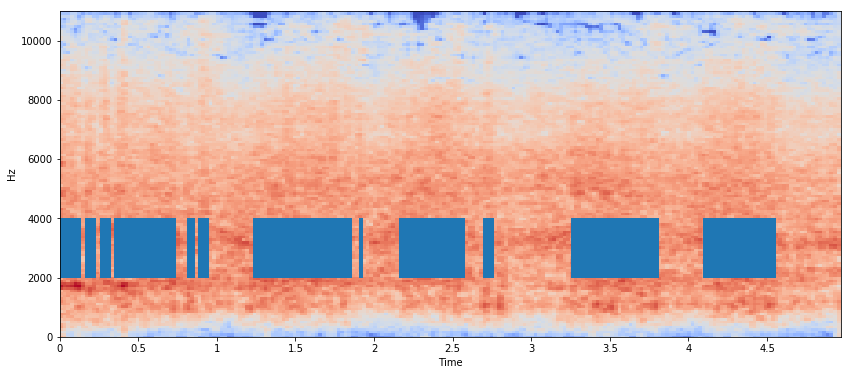

In [10]:
pca_detect(x, components=[0,1])

In [242]:
# do a 

## MFCC coefficients   -15/11/2020

MFCCs are mel frequency sepstral coefficients. Instead of using the spectralgram, can use this instead as model inputs. it is supposed to work well for things like speech. however, there is still some subtle differences between speech and this, as this has a lot more more difficult noise components than speech. 


Try treating it totally like speech and see what happens. 


In [39]:
def mfcc(x):
    x_mfcc = librosa.feature.mfcc(x,n_mfcc=20)
    ax = plt.subplot()
    librosa.display.specshow(x_mfcc, x_axis='time')
    plt.colorbar()
    plt.show()
    return x_mfcc

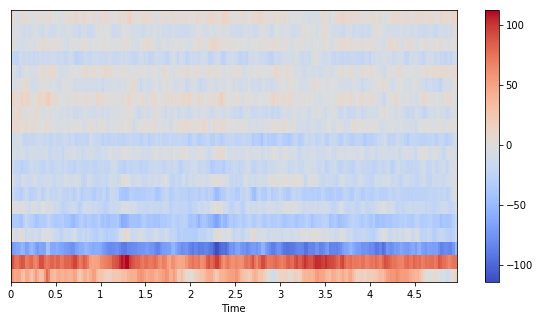

In [40]:
mfccs = mfcc(x)

### Calculate the derivatives and second derivatives of the mfcc 
This tells us how the mfcc evolves with time. 

In [41]:
delta_mfccs = librosa.feature.delta(mfccs)
delta2_mfccs = librosa.feature.delta(mfccs,order =2)


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

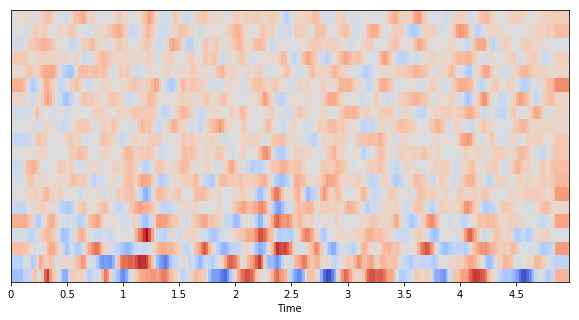

In [42]:
ax= plt.subplot()
librosa.display.specshow(delta_mfccs,ax=ax,x_axis="time")
plt.colorbar()
plt.show()

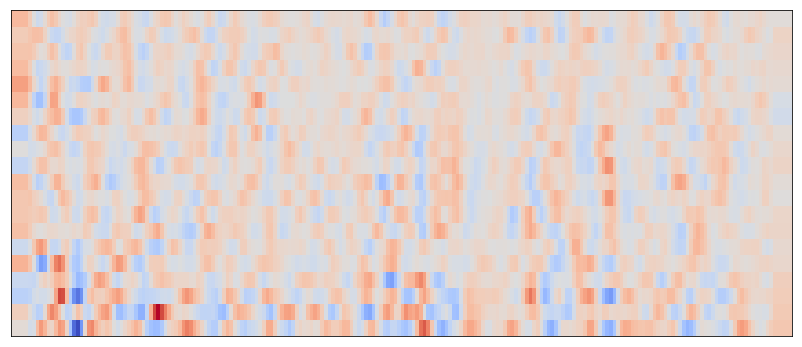

In [188]:
librosa.display.specshow(delta2_mfccs)

## mel frequency spectrogram  17/11/2020

The mel frequency spectrogram is supposed to be a very useful tool for speech. this allows some interpretability to be still retained, compared to the MFCCs. try to see if the signals are more obvious here. 

Text(0.5,1,'15db noise reduced signal')

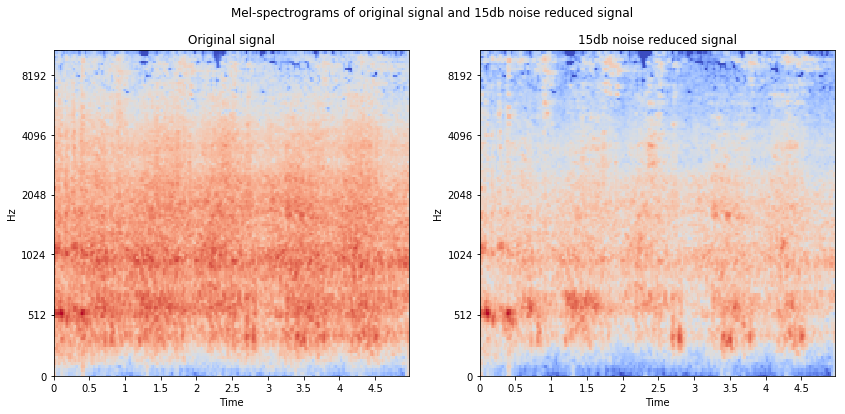

In [31]:
x_mel = librosa.power_to_db(abs(librosa.feature.melspectrogram(x,hop_length=512)))
x_mel_15 = librosa.power_to_db(abs(librosa.feature.melspectrogram(x_15,hop_length=512)))
fig, axs = plt.subplots(1,2)

fig.suptitle("Mel-spectrograms of original signal and 15db noise reduced signal")
librosa.display.specshow(x_mel,y_axis="mel",ax=axs[0],x_axis="time")
axs[0].set_title("Original signal")
librosa.display.specshow(x_mel_15,y_axis="mel",ax=axs[1],x_axis='time')

axs[1].set_title("15db noise reduced signal")


## Window function to divide a piece of audio into frames 17/11/2020

currently, the temporal resolution is given by 

$$ frame Interval = \frac{hop Length}{samplingRate}$$
 
This is about 23 ms for a frame. We would like to then keep this information, but take a window to the spectrogram and segment out longer frames. for example 20 frames gives us 0.4s features. We would like to keep the resolution so we are not doing any kind of averaging, as this is perhaps getting fed into a convolutional neural net.

However, keeping the temporal resolution means we perhaps can't do traditional machine learning, or making feature extraction more difficult. 

below is a function to hop along the spectrogram, segmenting at particular hop length and window lengths


In [36]:
def hop(x_ft,hop_size = 10, window_size = 20, average = False):
    segments = []
    for i in range(0,x_ft.shape[1],hop_size):
        
        if i+window_size <= x_ft.shape[1]:
            segment = x_ft[:,i:i+window_size]
            segments.append(segment)
    return segments 


    

(128, 20)


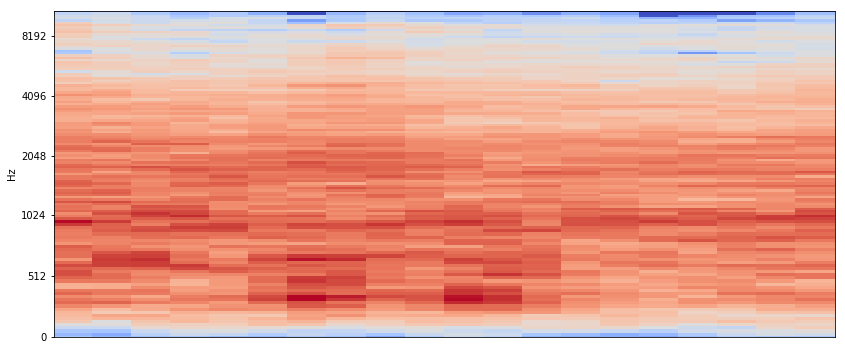

In [38]:
x_mel = librosa.power_to_db(abs(librosa.feature.melspectrogram(x,hop_length=512)))

x_mel_segs = hop(x_mel)
librosa.display.specshow(x_mel_segs[11],y_axis="mel")
print(x_mel_segs[11].shape)

## Looking at an actual piece of speech 


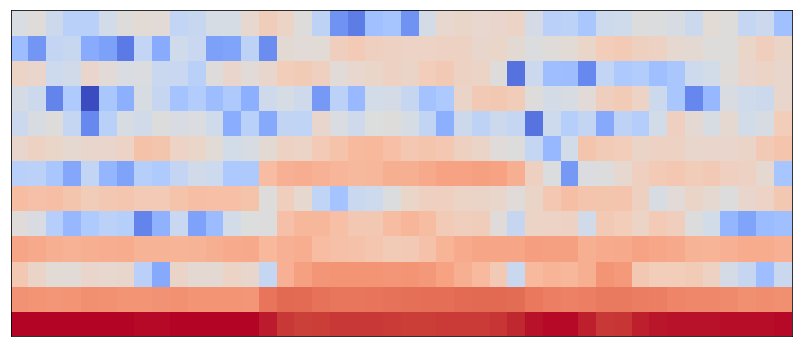

In [201]:
bed_audio,sr = librosa.load("bed.wav")
mfccs = librosa.power_to_db(abs(librosa.feature.mfcc(bed_audio, n_mfcc=13)))
librosa.display.specshow(mfccs)
